Checks for validation data splits created by scikit function.

In [1]:
import scipy.io as sio
from sklearn.model_selection import StratifiedKFold
from analysis_tree_helpers import HTree
import seaborn as sns
sns.set()
%matplotlib inline

base_data_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'

/home/rohan/miniconda3/envs/tf21-cpu/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


True


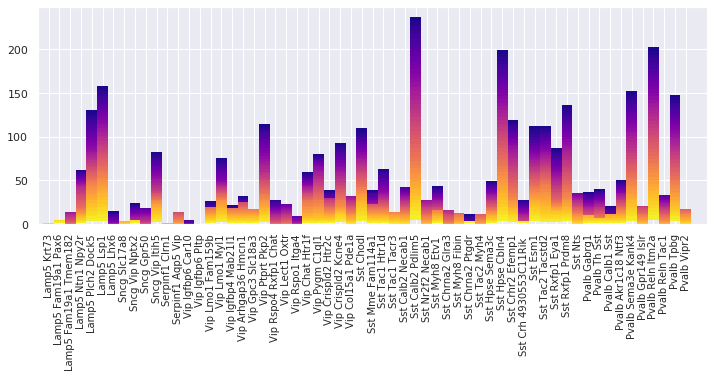

In [2]:
#Load raw data
D = sio.loadmat(base_data_path+'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)

#Get indices for the validation sets
skf = StratifiedKFold(n_splits=50, random_state=0, shuffle=True)
ind_dict = [{'train':train_ind, 'val':val_ind} for train_ind, val_ind in skf.split(X=np.zeros(shape=D['cluster'].shape), y=D['cluster'])]

#Get inhibitory tree, and order cell type names. 
htree = HTree(htree_file=base_data_path+'dend_RData_Tree_20181220.csv')
htree = htree.get_subtree(node='n59')
htree_df = htree.obj2df()
htree_df = htree_df[htree_df['isleaf']]
htree_df = htree_df.sort_values(by='x', axis=0).reset_index(drop=True)
ordered_ctypes = htree_df.child.tolist()

#Get counts per celltype in individual validation splits
ctype_counts_per_split = np.zeros((len(ordered_ctypes),len(ind_dict)),dtype=int)
for i in range(len(ind_dict)):
    data_cluster = D['cluster'][ind_dict[i]['val']]
    temp = [np.sum(data_cluster==ctype) for ctype in ordered_ctypes]
    ctype_counts_per_split[:,i] = np.array(temp)
    
total_ctype_counts = ctype_counts_per_split.sum(axis=1)
ground_truth = np.array([np.sum(D['cluster']==ctype) for ctype in ordered_ctypes])
print(np.array_equal(total_ctype_counts,ground_truth))

cum_ctype_counts = np.cumsum(ctype_counts_per_split,axis=1)

plt.figure(figsize=(12,4))
cmap=plt.get_cmap('plasma')
for i in range(len(ind_dict)):
    if i >0:
        plt.bar(x = np.arange(np.shape(ctype_counts_per_split)[0]),
                height = ctype_counts_per_split[:,i], 
                width=1, 
                bottom=cum_ctype_counts[:,i-1], 
                color=cmap(1 - i/len(ind_dict)),
                edgecolor='None',
                alpha=1)
ax = plt.gca()
ax.set_xticks(np.arange(np.shape(ctype_counts_per_split)[0]))
ax.set_xticklabels(ordered_ctypes,rotation=90,fontsize=10)
ax.set_xlim(-1,61)
plt.show()

**Low and high quality distribution (based on T mapping)**

In [3]:
low_conf = np.isin(D['map_conf'],['I2','I3'])
ctype_counts = [np.sum(D['cluster']==ctype) for ctype in ordered_ctypes]
ctype_counts_low_quality = [np.sum(D['cluster'][low_conf]==ctype) for ctype in ordered_ctypes]
ctype_counts_high_quality = [np.sum(D['cluster'][~low_conf]==ctype) for ctype in ordered_ctypes]

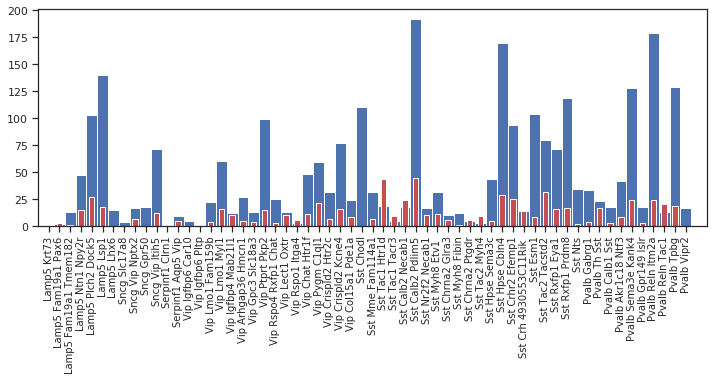

In [8]:
plt.figure(figsize=(12,4))
plt.bar(x = np.arange(np.size(ctype_counts_high_quality)),
        height = ctype_counts_high_quality, 
        width=1, 
        color='b')
plt.bar(x = np.arange(np.size(ctype_counts_low_quality)),
        height = ctype_counts_low_quality, 
        width=0.5, 
        color='r')

ax = plt.gca()
ax.set_xticks(np.arange(np.size(ctype_counts_low_quality)))
ax.set_xticklabels(ordered_ctypes,rotation=90,fontsize=10)
ax.set_xlim(-1,61)
plt.show()

**Distribution for well sampled cell types**

In [5]:
min_counts = 10
counts = []
labels = []
for ctype in ordered_ctypes:
    c = np.sum(D['cluster']==ctype)
    if c>min_counts:
        counts.append(c)
        labels.append(ctype)
        
counts = np.array(counts)
labels = np.array(labels)
x = np.arange(labels.size)

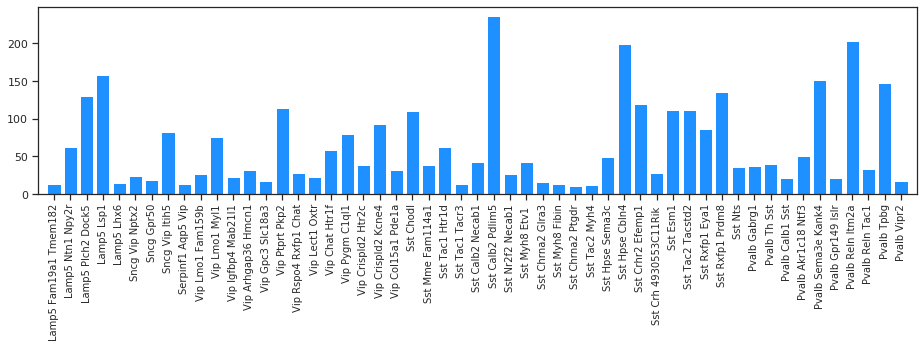

In [6]:
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
plt.figure(figsize=(13,5))
plt.bar(x,counts,color='dodgerblue')
ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90,fontsize=10)
ax.set_xlim(-1,53)
plt.tight_layout()
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/TypeDistribution.png',dpi=300)
plt.show()